# Exact Exchange Calculations 
**by <span style="color:darkgreen">Ute Werner</span> for [<span style="color:darkgoldenrod">exciting *fluorine*</span>](http://exciting.wikidot.com/fluorine)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will learn how to perform band-structure calculations using the optimized effective potential - exact-exchange (**EXX**) method. As an example, the band structure of diamond is calculated.
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">

**Table of Contents**
    
[0. Before Starting](#0)
    
[1. Introduction](#1)  
    
[2. LDA Calculation](#2)
   - Preparation of the Calculation
   - Execute the Calculation 

[3. Exact-Exchange Calculation](#3)
   - Preparation of the Input File
   - Execute the Calculation 
    
[4. Post Processing](#4)

[5. Excercise](#5)      

[6. Literature](#6)
</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from exciting's root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

As a first step, you may set the **exciting_root** directory and create a running directory for the notebook.

In [ ]:
import os
from excitingjupyter.utilities import get_exciting_root, check_for_binary

exciting_root = get_exciting_root()
check_for_binary(exciting_root)
exciting_species = os.path.join(exciting_root, "species")
print(exciting_root)

In [ ]:
%%bash
mkdir run_tutorial_exact_exchange_calculations

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Introduction</span>

A typical exact exchange (**EXX**) calculation consists of two parts. Initially a ground state self-consistent cycle, for example with **LDA**, is performed to create good Kohn-Sham orbitals as initial guess for the **EXX** calculation. Afterwards, starting from these data, a self consistent **EXX** calculation is executed.

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. LDA Calculation</span>

We start by performing an **LDA** calculation for comparing with **EXX**. This initial **LDA** calculation is not related to the initial self-consistent cycle performed at the beginning of the **EXX** calculation, since the latter is done internally by exciting.

As usual, the first thing to do is to create the subdirectory for the **LDA** calculation.

In [ ]:
%%bash
cd run_tutorial_exact_exchange_calculations
mkdir LDA
cd ..

#### <span style="color:#15317E">i) Preparation of the Calculaion</span>

Create an input file input.xml for the ground-state and band-structure calculation of diamond using LDA which could look like this

```xml
<input>
 
   <title>Diamond LDA</title>
 
   <structure speciespath="$EXCITINGROOT/species" >
      <crystal scale="6.7425">
         <basevect> 0.0     0.5     0.5 </basevect>
         <basevect> 0.5     0.0     0.5 </basevect>
         <basevect> 0.5     0.5     0.0 </basevect>
      </crystal>
      <species speciesfile="C.xml">
         <atom coord="0.00 0.00 0.00" />
         <atom coord="0.25 0.25 0.25" />
      </species>
   </structure>
 
   <groundstate 
      ngridk="8 8 8"
      xctype="LDA_PW">
   </groundstate>
 
   <properties>
      <bandstructure>
         <plot1d>
            <path steps="200">
               <point coord="1.0     0.0     0.0" label="Gamma"/>
               <point coord="0.625   0.375   0.0" label="K"/>
               <point coord="0.5     0.5     0.0" label="X"/>
               <point coord="0.0     0.0     0.0" label="Gamma"/>
               <point coord="0.5     0.0     0.0" label="L"/> 
            </path>
         </plot1d>
      </bandstructure>
   </properties>
 
</input>
```

This can be done by writing the complete input as a string and saving it in your working directory as **input.xml**.

In [ ]:
from excitingjupyter.utilities import re_input

# Convert markdown cell with input to string:
notebook = "tutorial_exact_exchange_calculations.ipynb"
xml_str = re_input(notebook, "Diamond LDA")
input_str_LDA = xml_str.replace("$EXCITINGROOT/species", f"{exciting_species}")

# Write out the input as an XML file:
with open(os.path.join(os.getcwd(), 'run_tutorial_exact_exchange_calculations/LDA/input.xml'), "w") as fid:
    fid.write(input_str_LDA)

#### <span style="color:#15317E">ii) Execute the Calculation</span>

In order to run **exciting** from the terminal, you simply need to execute the **exciting_smp** binary in the running directory. After a few seconds, the calculation should be finished.

Here we used the <code>time</code> command before **exciting_smp** in order to get, at the end of the run, the elapsed time explicitly written on the screen.

**Be sure** that your calculation is completed before proceeding with the next steps!

In [ ]:
%%bash
cd run_tutorial_exact_exchange_calculations/LDA
# Set up environment. Note that this is platform-specific. With the Modules package you can e.g. use:
module load intel
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ../..

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Exact-Exchange Calculation</span>

#### <span style="color:#15317E">i) Preparation of the Calculaion</span>

In the next step, we will calculate the ground state and band structure using **EXX**. Therefore, replace the <code><span style="color:green">groundstate</span></code>  section in the file **input.xml** with the following lines.

```xml
...
   <groundstate 
      ngridk="3 3 3"
      xctype="EXX"
      vkloff="0.5 0.5 0.5"
      nempty="29">
 
      <OEP 
         maxitoep="100"> 
      </OEP>
 
   </groundstate>
...

```

In [ ]:
%%bash
cd run_tutorial_exact_exchange_calculations
mkdir EXX
cd ..

In [ ]:
groundstate_EXX = """<groundstate 
      ngridk="3 3 3"
      xctype="EXX"
      vkloff="0.5 0.5 0.5"
      nempty="29">
 
      <OEP 
         maxitoep="100"> 
      </OEP>
      
     </groundstate>
"""

index1=input_str_LDA.find("<groundstate")
index2=input_str_LDA.find("<properties>")

input_str_EXX = input_str_LDA[:index1] + groundstate_EXX +"\n"+ input_str_LDA[index2:]

with open(os.path.join(os.getcwd(), 'run_tutorial_exact_exchange_calculations/EXX/input.xml'), "w") as fid:
    fid.write(input_str_EXX)

Let's have a closer look to the parameters in this file.

Parameter|Description
:-----------|:--------------------------------
<code><span style="color:mediumblue">xctype</span></code>=**"EXX"**|The calculation is performed using the exact-exchange functional.
<code><span style="color:mediumblue">nempty</span></code>=**"29"**|The number of empty bands, crucial for the convergence.
<code><span style="color:mediumblue">vkloff</span></code>=**"0.5 0.5 0.5"**|The origin of the k-point grid, crucial for the convergence.
<code><span style="color:mediumblue">maxitoep</span></code>=**"100"**|The number of iterations for the evaluation of integrals in **EXX**.

Since the **EXX** calculations are much more time consuming than corresponding **LDA** ones, computational parameters have been chosen in a way to speed up the calculation. However, the calculation will still last approximately 10-20 min. For further details on the parameters see [**Input Reference**](http://exciting.wikidot.com/ref:input).

#### <span style="color:#15317E">ii) Execute the Calculation</span>

In [ ]:
%%bash
cd run_tutorial_exact_exchange_calculations/EXX
# Set up environment. Note that this is platform-specific. With the Modules package you can e.g. use:
module load intel
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ../..

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Post Processing</span>



In [2]:
from excitingtools.exciting_obj_parsers.ks_band_structure import parse_band_structure

bandstructure_LDA_xml = os.path.join(os.getcwd(), 'run_tutorial_exact_exchange_calculations/LDA/bandstructure.xml')
bandstructure_EXX_xml = os.path.join(os.getcwd(), 'run_tutorial_exact_exchange_calculations/EXX/bandstructure.xml')

band_data_LDA = parse_band_structure(bandstructure_LDA_xml)
band_data_EXX = parse_band_structure(bandstructure_EXX_xml)

band_data_LDA.e_fermi = band_data_EXX.e_fermi = 0.0
band_data_LDA.i_vbm =  band_data_LDA.get_band_edges()[0]
band_data_EXX.i_vbm =  band_data_EXX.get_band_edges()[0]

vertices, labels = band_data_LDA.band_path()

In [3]:
from scipy.constants import physical_constants

ha_to_ev = physical_constants["hartree-electron volt relationship"][0]

vbm_LDA = band_data_LDA.get_valence_band_maximum()
vbm_EXX = band_data_EXX.get_valence_band_maximum()

band_data_LDA.bands = (band_data_LDA.bands - vbm_LDA) * ha_to_ev
band_data_EXX.bands = (band_data_EXX.bands - vbm_EXX) * ha_to_ev

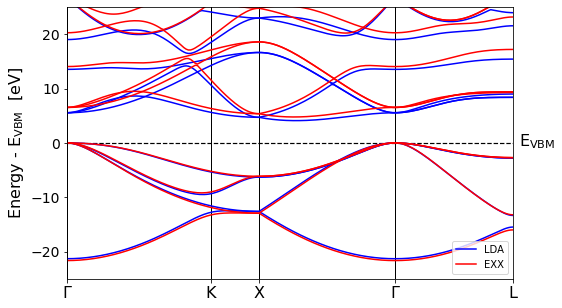

In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(8,5))
plt.ylabel("Energy - $\mathregular{E_{VBM}}$  [eV]", fontsize=16)
plt.ylim([-25, 25])
plt.xlim([vertices[0], vertices[-1]])

plt.xticks(ticks=vertices, labels=labels, fontsize=16)
plt.yticks(fontsize=14)
plt.rcParams["axes.linewidth"] = 2

plt.axhline(y=band_data_LDA.e_fermi, color="black", linestyle='--', linewidth=1.2)

for i in range(len(band_data_LDA.vertices)):
    plt.axvline(x=vertices[i], color="black", linewidth=1)

plt.text(3.1, -0.6, "$\mathregular{E_{VBM}}$", fontsize=16)

plt.plot(band_data_LDA.flattened_k_points, band_data_LDA.bands, color="blue")
plt.plot(band_data_EXX.flattened_k_points, band_data_EXX.bands, color="red")

LDA_label = Line2D([0], [0], label='LDA', color='blue')
EXX_label = Line2D([0], [0], label='EXX', color='red')
plt.legend(handles=[LDA_label,EXX_label], loc='lower right')

plt.show()

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">5. Excercise</span>

Try to modify some of the parameters in the <code><span style="color:green">groundstate</span></code> element of the **EXX** input file and investigate the effect on the band structure and on the computational time.

<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">6. Literature</span>

- S. Sharma, J. K. Dewhurst, and C. Ambrosch-Draxl, Phys. Rev. Lett. **95**, 136402 (2005); S. Sharma, J. K. Dewhurst, C. Ambrosch-Draxl, S. Kurth, N. Helbig, S. Pittalis, S. Shallcross, L. Nordström, and E. K. U. Gross, Phys. Rev. Lett. **98**, 196405 (2007)

<hr style="border:2px solid #DDD"> </hr>